In [1]:
import xgboost
import shap 

import numpy as np
from cell_paint_seg.utils import get_id_to_path, check_valid_labels, threat_score
from cell_paint_seg.image_io import read_ims, read_seg
from skimage import io, exposure, measure, transform
from pathlib import Path
import napari
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import umap
import umap.plot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score 
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (co

In [5]:
def id_from_name_dataset(name):
    id = name[:-7]
    return id 

def condition_from_id(id):
    row_to_roid = {"B":0, "C":1, "D":2, "E":3, "F":4, "G":5}

    well = id.split("_")[1]
    row = well[1]
    row = row_to_roid[row]
    col = int(well[2:])
    col -= 2

    conditions = [[1,1,2,2,5,1,1,4,5,5],
                  [3,3,4,4,5,2,2,4,3,3],
                  [5,2,2,1,1,2,2,3,3,5],
                  [3,3,4,4,5,5,4,4,1,1],
                  [4,4,1,1,3,2,2,1,3,3],
                  [5,5,2,2,3,5,5,1,4,4]]
    
    return conditions[row][col] - 1

def line_from_id(id):
    row_to_roid = {"B":0, "C":1, "D":2, "E":3, "F":4, "G":5}

    e = int(id[1])
    well = id.split("_")[1]
    row = well[1]
    row = row_to_roid[row]
    col = int(well[2:])

    if row < 2:
        if col < 7:
            e_to_line = {1:"RFTiALS", 2:"AE8iCTR", 3:"ADKiCTR", 4:"EGMiALS"}
        else:
            e_to_line = {1:"AE8iCTR", 2:"BFUiALS", 3:"ZLMiALS", 4:"XH7iCTR"}
    elif row < 4:
        if col < 7:
            e_to_line = {1:"ZKZiCTR", 2:"KRCiALS", 3:"BFUiALS", 4:"ADKiCTR"}
        else:
            e_to_line = {1:"TJViALS", 2:"XH7iCTR", 3:"NK3iCTR", 4:"LJXiALS"}
    else:
        if col < 7:
            e_to_line = {1:"DG9iALS", 2:"ZKZiCTR", 3:"ZKZiCTR", 4:"NK3iCTR"}
        else:
            e_to_line = {1:"XH7iCTR", 2:"RJViALS", 3:"AFGiALS", 4:"AE8iCTR"}
    
    
    return e_to_line[e]

path_dataset = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/processed"


cond_to_cond = {1: "KPT", 2:"H2O2", 3:"Tunicamycin", 4:"Autophagy", 5:"DMSO"}
channels = ["ER", "DNA", "Mito", "Actin", "RNA", "Golgi/membrane"]
res = 6.9e-7

id_to_path = get_id_to_path(path_dataset, tag=".tif", id_from_name=id_from_name_dataset)

print(f"{len(id_to_path.keys())} samples found")

720 samples found


In [ ]:
# Configuration
data_dir = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/processed_copy"  # Path to dataset (train and val subdirectories)
num_classes = 2             # Number of target classes
batch_size = 32                 # Batch size
num_epochs = 10                 # Number of epochs
learning_rate = 0.001           # Learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations and loaders
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize and crop to 224x224
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize(256),            # Resize smaller edge to 256
    transforms.CenterCrop(224),        # Crop center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

: 

In [ ]:
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pretrained model and modify classifier
model = models.resnet18(pretrained=True)  # Replace with other models if needed
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify final layer
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Run training
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# Save the model
torch.save(model.state_dict(), "finetuned_model.pth")
print("Model saved as finetuned_model.pth")

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
img.dtype

dtype('float32')

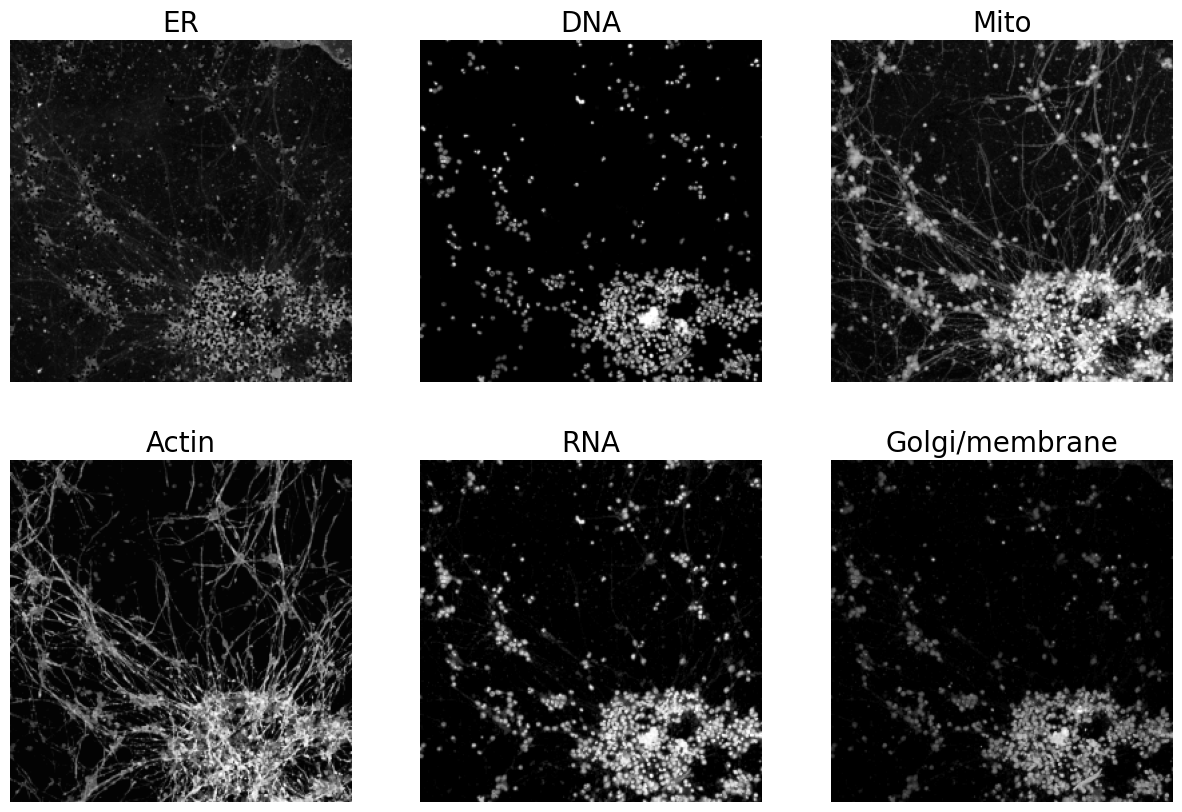

In [22]:
image = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/als_v_control_2/train/e1_wB2_f1.npy"
image = np.load(image)


f, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, channel in enumerate(channels):
    img = image[i]
    img /= img.max()
    # downsample img to 256x256
    img = transform.resize(img, (256, 256))
    # apply clahe to enhance contrast
    img = exposure.equalize_adapthist(img, clip_limit=0.02)#, kernel_size=64)
    ax[i//3, i%3].imshow(img, cmap="gray")
    ax[i//3, i%3].set_title(channel)
    ax[i//3, i%3].axis("off")
    # increase font size of title
    ax[i//3, i%3].title.set_fontsize(20)

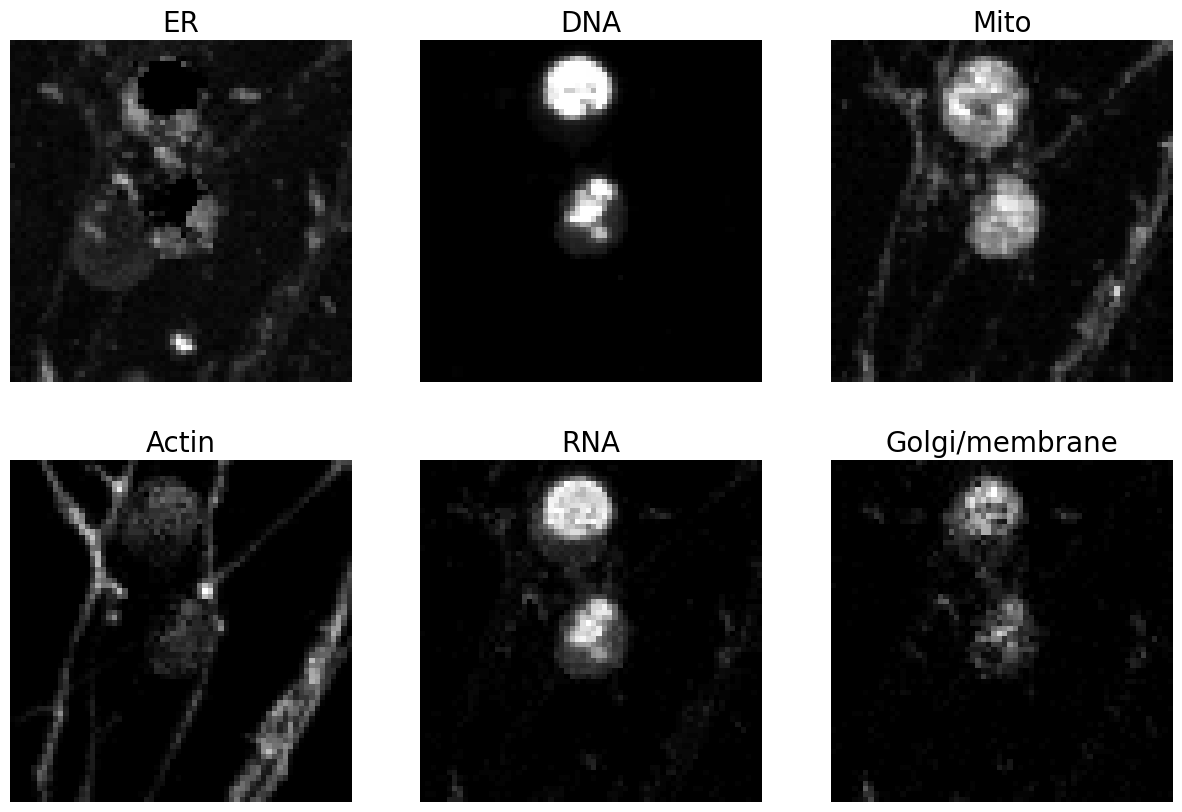

In [24]:
image = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/patches_balanced_clahe/e1_wB2_f1_41_632.npy"
image = np.load(image)


f, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, channel in enumerate(channels):
    img = image[i]
    #img /= img.max()
    # downsample img to 256x256
    #img = transform.resize(img, (256, 256))
    # apply clahe to enhance contrast
    #img = exposure.equalize_adapthist(img, clip_limit=0.02)#, kernel_size=64)
    ax[i//3, i%3].imshow(img, cmap="gray")
    ax[i//3, i%3].set_title(channel)
    ax[i//3, i%3].axis("off")
    # increase font size of title
    ax[i//3, i%3].title.set_fontsize(20)